In [1]:
import os 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import re
import numpy as np
import shutil
from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot

pd.options.plotting.backend = "plotly"

In [15]:
def get_df_experiment(ExperimentDataPath):
    df_ref = pd.read_csv(ExperimentDataPath)
    col2  = []
    for col in df_ref.columns:
        col2.append(str(col).strip(' '))
    df_ref.columns = col2
    df_ref['d'] = df_ref['Y']/1000
    return df_ref


def get_measurements(df_exp,phi):
    x,y = df_exp["d"].values,df_exp["Phi{}".format(phi)].values
    x2,y2 = [],[]
    i = 0
    imax = None
    while (imax == None and i < len(x)):
        if (type(y[i]) not in [float,np.float64,np.float32] and re.search("\d",y[i]) == None):
            imax = i
        i += 1
    return x[:imax].astype(float),y[:imax].astype(float)


def process_profile(Iter_profile,Profiles_Path,phi):
    filename = "Radial{}deg_".format(phi)+Iter_profile+".csv"
    Phi_Profile_Path = Profiles_Path.joinpath(filename)

    df = pd.read_csv(Phi_Profile_Path)
    col2  = []
    for col in df.columns:
        col2.append(str(col).strip(' '))
    df.columns = col2

    d = 0.1404
    #Rod center coords
    x0 = -d
    y0 = 0
    #Rod radius
    r = 0.06
    #Angle from Ox 
    #WARNING domain between 60 and 30deg teta = 60-Phi
    teta = np.pi/180*(60-phi)

    xg = r*np.cos(teta) + x0
    yg = r*np.sin(teta) + y0

    xh = d/(3**0.5*np.tan(teta)+1) + x0
    yh = d*np.tan(teta)/(3**0.5*np.tan(teta)+1) + y0

    distanceHG = ((xh-xg)**2+(yh-yg)**2)**0.5
    df["d"] = df["s"]*distanceHG
    return df["d"].values.astype(float),df["Velocity_z"].values.astype(float)


def plot_profiles(ExperimentDataPath,Iter_profile_l,Profiles_Path_l,phi_l,label_l):
    df_exp = get_df_experiment(ExperimentDataPath)
    n = len(phi_l)
    width = 6
    marker_l = ["^","P","*","X","s"]
    color_l = ["r","g","k","m","y"]
    #fig,axes = plt.subplots(n,figsize=(width,n*width))
    for i in range(n):
        plt.figure()
        phi = phi_l[i]
        x_exp,y_exp = get_measurements(df_exp,phi)
        plt.plot(x_exp,y_exp,label="Experiment",marker='o',linestyle='--',color='b')
        for i in range(len(Profiles_Path_l)):
            x_cfd,y_cfd = process_profile(Iter_profile_l[i],Profiles_Path_l[i],phi)
            plt.plot(x_cfd,y_cfd,label=label_l[i],marker=marker_l[i],linestyle='--',color=color_l[i])
        plt.title("Phi: {}".format(phi))
        plt.xlabel("Y (mm)")
        plt.ylabel("W (m.s^-1)")
        plt.legend()

def process_stress(csv):
    head = re.compile("x,y,z,phi,Tau_n,Tau_t")
    temp_file = Path("temp.csv")
    header_found = False
    with open(csv, "r") as input:
        with open(temp_file, "w") as output:
            for line in input:
                if head.match(line):
                    if header_found != True:
                        output.write(line)
                        header_found = True
                else:
                    output.write(line)
    p = Path(csv).parents[0]
    shutil.move(temp_file,p)
    os.remove(csv)
    p2 = p.joinpath(temp_file)
    os.rename(p2,Path(csv))

def plot_stress(Exp_Data,Stress_P_l,Iter_l,label_l):
    fig,ax   = plt.subplots()
    fig2,ax2 = plt.subplots()
    marker_l = ["^","P","*","X","s"]
    color_l = ["r","g","k","m","y"]

    df_tau_exp = pd.read_csv(Exp_Data)
    df_tau_exp=df_tau_exp.astype(float).sort_values(by=["Phi"])
    df_tau_exp["181200_avg"] = df_tau_exp["181200"]/df_tau_exp["181200"].mean()

    ax.plot(df_tau_exp["Phi"],df_tau_exp["181200_avg"],label="Experiment",marker='o',linestyle='--',color='b') 
    ax2.plot(df_tau_exp["Phi"],df_tau_exp["181200"],label="Experiment",marker='o',linestyle='--',color='b') 

    for i in range(len(Stress_P_l)):
        if Iter_l[i] != "":
            S_csv = Stress_P_l[i].joinpath("Stress-{}.csv".format(Iter_l[i]))
        else:
            S_csv = Stress_P_l[i]
        process_stress(S_csv)
        df_s = pd.read_csv(S_csv)
        if 'Points_0' in  df_s.columns:
            df_s = df_s[['Points_0', 'Points_1', 'Points_2','Shear_Stress_Magnitude']].copy(True)
            df_s.columns = ["x","y","z","Tau_t"]
            df_s["phi"] = 60-180/np.pi*np.arctan2(df_s["y"],df_s["x"]+0.1404)
        df_s = df_s.sort_values(by=["phi"])
        df_s["Tau_t_avg"] = df_s["Tau_t"]/df_s["Tau_t"].mean()
        ax.plot(df_s["phi"],df_s["Tau_t_avg"],label=label_l[i],marker=marker_l[i],linestyle='--',color=color_l[i])
        ax2.plot(df_s["phi"],df_s["Tau_t"],label=label_l[i],marker=marker_l[i],linestyle='--',color=color_l[i])
    
    ax.set_title("Relative shear stress")
    ax.set_xlabel("Phi")
    ax.set_xlim(left=0)
    ax.legend()
    #fig.savefig('ShearStress.pgf')

    ax2.set_title("Absolute shear stress value")
    ax2.set_xlabel("Phi")
    ax2.set_ylabel("Shear Stress (Pa)")
    ax2.legend()
    ax2.set_xlim(left=0)
    plt.show()


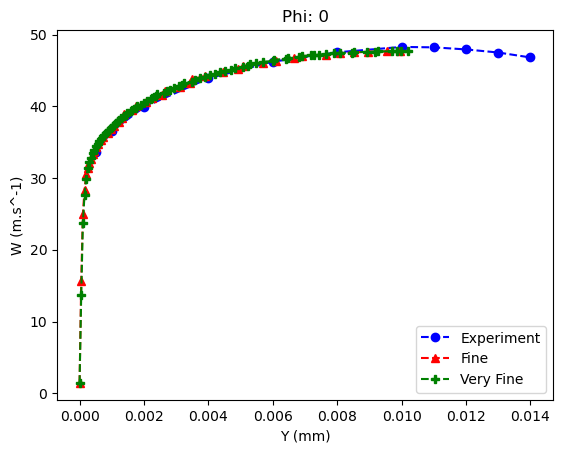

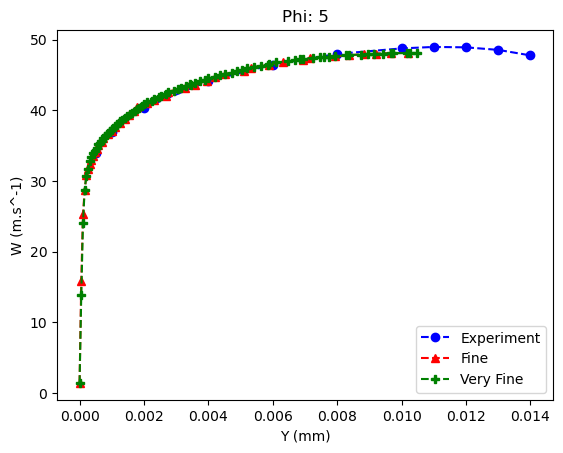

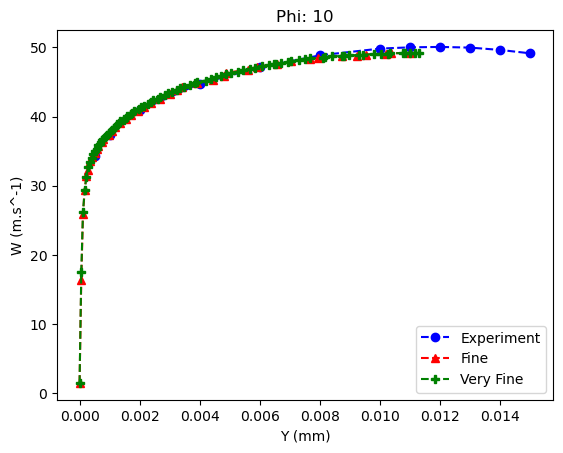

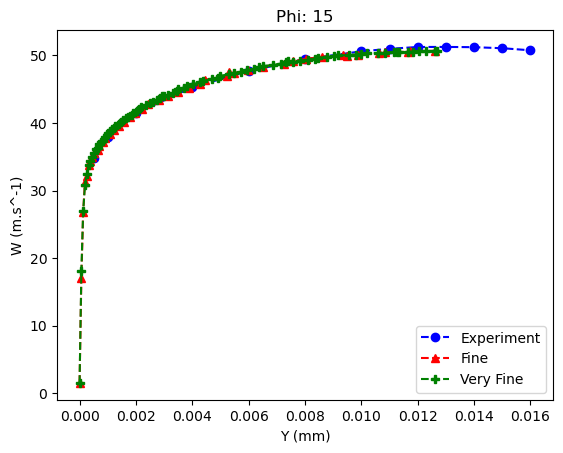

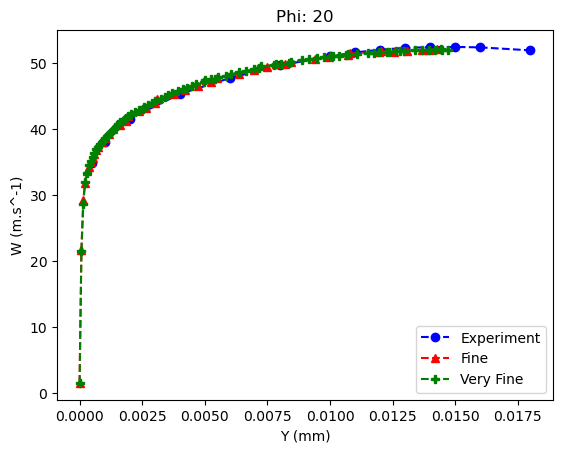

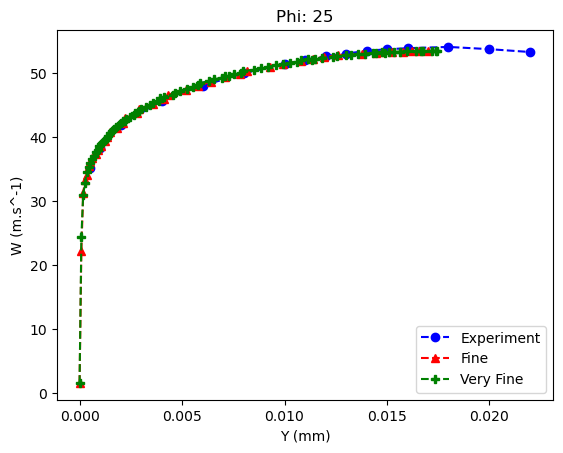

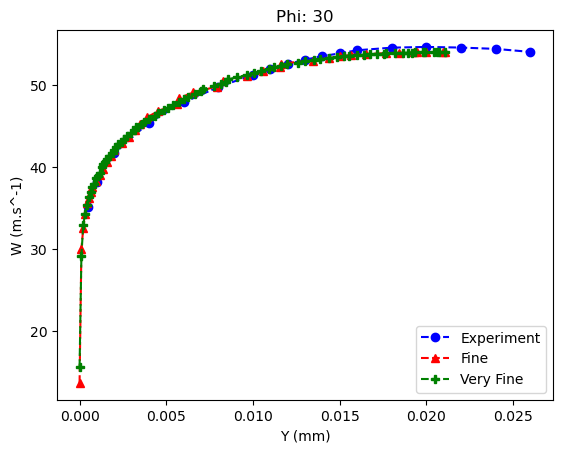

In [16]:
ExperimentDataPath = Path("/home/juleslecoustre/Documents/FuelRod/Re181200FiW.csv")
Profiles_Path = Path("/home/juleslecoustre/Documents/FuelRod/StarMesh/RESU/PatchesMeshLREpt_1_Coarse3/profiles")
Profiles_Path2 = Path("/home/juleslecoustre/Documents/Acqua/FuelRod/Cubic_fine/profiles")
S_LRE_SKE1mm = Path("/home/juleslecoustre/Documents/FuelRod/StarMesh/RESU/SKE_Fine_patch/profiles")
S_LRE_Quad05mm = Path("/home/juleslecoustre/Documents/Acqua/FuelRod/Cubic_very_fine/profiles")
S_LRE_Quad05mm = Path("/home/juleslecoustre/Documents/Acqua/FuelRod/Cubic_ultra_fine/profiles")


S_LRE_CUBIC_fine = Path("/home/juleslecoustre/Documents/Acqua/FuelRod/Cubic_very_fine/profiles")

S_LRE_CUBIC_ultrafine = Path("/home/juleslecoustre/Documents/Acqua/FuelRod/Cubic_ultra_fine/profiles")

Profiles_Path_list = [S_LRE_CUBIC_fine,S_LRE_CUBIC_ultrafine]
Iter_profile_l = ["40000","58443"]
label_l = ["Fine","Very Fine"]

phi_list = [0,5,10,15,20,25,30]
plot_profiles(ExperimentDataPath,Iter_profile_l,Profiles_Path_list,phi_list,label_l)

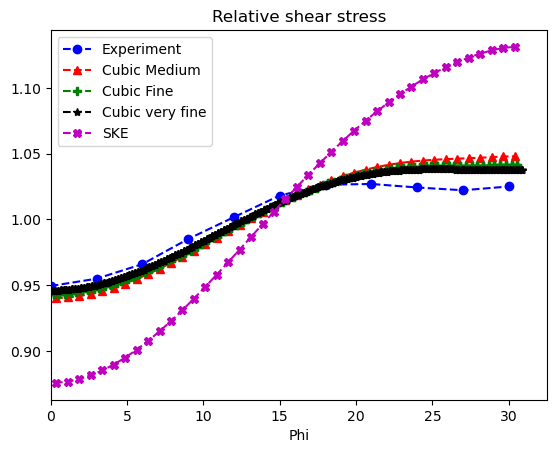

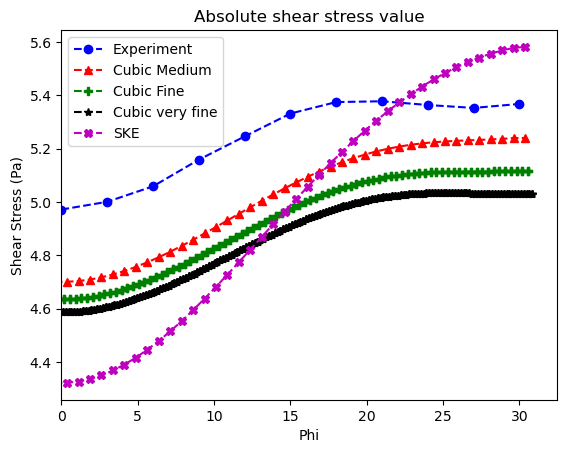

In [14]:
## LOW REYNOLDS

ExperimentDataPath_Tau = Path("/home/juleslecoustre/Documents/FuelRod/Tau.csv")
S_SKE_1mm = Path("/home/juleslecoustre/Documents/FuelRod/StarMesh/RESU/SKE_Fine_patch")

S_LRE_QUAD_medium = Path("/home/juleslecoustre/Documents/Acqua/FuelRod/Quad_fine")
S_LRE_QUAD_fine = Path("/home/juleslecoustre/Documents/Acqua/FuelRod/Quad_very_fine")

S_LRE_CUBIC_medium = Path("/home/juleslecoustre/Documents/Acqua/FuelRod/Cubic_fine")
S_LRE_CUBIC_fine = Path("/home/juleslecoustre/Documents/Acqua/FuelRod/Cubic_very_fine")

S_LRE_CUBIC_ultrafine = Path("/home/juleslecoustre/Documents/FuelRod/StarMesh/RESU/CSV/Stress-055000.csv")

Iter_profile_l = ["030000","040000","","002000"]
Stress_l = [S_LRE_CUBIC_medium,S_LRE_CUBIC_fine,S_LRE_CUBIC_ultrafine,S_SKE_1mm]
lab_l = ["Cubic Medium","Cubic Fine","Cubic very fine","SKE"]


plot_stress(ExperimentDataPath_Tau,Stress_l,Iter_profile_l,lab_l)

In [ ]:
"""matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})"""
